# Hawkes LSTM model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import glob
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:
/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


## Loading synthetic data

We will be loading simulated Hawkes data.

In [7]:
import glob
import pickle

SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181201-002801.pkl


In [8]:
# SET THESE PARAMETERS
process_dim = 1
print("Process dimension: {}".format(process_dim))
choose_file_index = 0
chosen_data_file = SYNTH_DATA_FILES[choose_file_index]
print("Data file: {}".format(chosen_data_file))

Process dimension: 1
Data file: ../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl


In [9]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)

Loading 1-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	1.0
alpha	0.2
decay	3.0
tmax	80.0


In [10]:
print(seq_lengths.shape)

torch.Size([6000])


## Training

The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t))
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$

with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [11]:
import models.ctlstm
from models.ctlstm import HawkesLSTM, HawkesLSTMGen
from train_functions import train_neural_ctlstm, plot_loss

In [12]:
# define training data
train_size = 3000
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 3000
Train event times shape torch.Size([3000, 158])
Train event types shape torch.Size([3000, 158])
Train seq lengths shape torch.Size([3000])


In [ ]:
process_dim = 1
hidden_size = 16
model = HawkesLSTM(process_dim, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.021)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 10

loss_hist = train_neural_ctlstm(model, optimizer, train_times_tensor,
                                train_seq_types, train_seq_lengths, tmax,
                                BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 10



epoch 1: train loss 88.3672



epoch 2: train loss 71.8222



epoch 3: train loss 53.6930



epoch 4: train loss 34.9206



epoch 5: train loss 25.5282



epoch 6: train loss 21.3445


In [ ]:
from train_functions import plot_loss

In [ ]:
plot_loss(EPOCHS, loss_hist)

In [468]:
import datetime

ts = '{:%Y%m%d-%H%M%S}'.format(datetime.datetime.now())

flname = '{:}-{:}.pth'.format(nhlstm.__class__.__name__, ts)
print(flname)
fpath = '../saved_models/{:}'.format(flname)
print(fpath)

torch.save(nhlstm.state_dict(), fpath)

## Event generation

In [46]:
import models.ctlstm
from models.ctlstm import CTGenerator

In [48]:
neural_gen = CTGenerator(model)

In [50]:
neural_gen.generate_sequence(tmax)

TypeError: forward() missing 1 required positional argument: 'cell_target'

In [514]:
print(len(neural_gen.sequence_))

39


In [515]:
neural_gen.hidden_hist[0]

{'hidden': tensor([[ 0.0185,  0.0377,  0.0271,  0.0132,  0.0016, -0.0958,  0.0374,  0.0326,
          -0.1006,  0.0514, -0.1263, -0.0239]]),
 'cell': tensor([[ 0.0365,  0.0668,  0.0466,  0.0222,  0.0029, -0.1620,  0.0758,  0.0574,
          -0.1577,  0.1070, -0.2209, -0.0525]]),
 'cell_target': tensor([[ 0.0401,  0.0708,  0.0512,  0.0215,  0.0022, -0.1965,  0.0756,  0.0483,
          -0.1255,  0.0956, -0.2121, -0.0654]]),
 'cell_decay': tensor([[0.3643]]),
 'output': tensor([[0.5074, 0.5651, 0.5829, 0.5945, 0.5715, 0.5962, 0.4948, 0.5689, 0.6430,
          0.4820, 0.5808, 0.4562]])}

In [516]:
neural_gen.hidden_hist[-1]

{'hidden': tensor([[-0.7383,  0.7450,  0.5286, -0.8176, -0.6558, -0.8804,  0.7081,  0.3822,
          -0.8066,  0.4618, -0.8085, -0.0481]]),
 'cell': tensor([[-1.9994,  1.4745,  1.3537, -2.2451, -2.0242, -2.5285,  2.3079,  0.8697,
          -2.3529,  0.9697, -2.1861, -0.0948]]),
 'cell_target': tensor([[-0.7901,  0.6861,  0.9328, -0.7325, -0.7612, -0.6029,  0.8901,  0.4153,
          -0.5232,  0.7814, -0.8114, -0.1161]]),
 'cell_decay': tensor([[0.2839]]),
 'output': tensor([[0.7659, 0.8274, 0.6042, 0.8361, 0.6791, 0.8916, 0.7223, 0.5451, 0.8213,
          0.6169, 0.8292, 0.5094]])}

Text(0.5, 1.0, 'Evolution of the cell decay with each event')

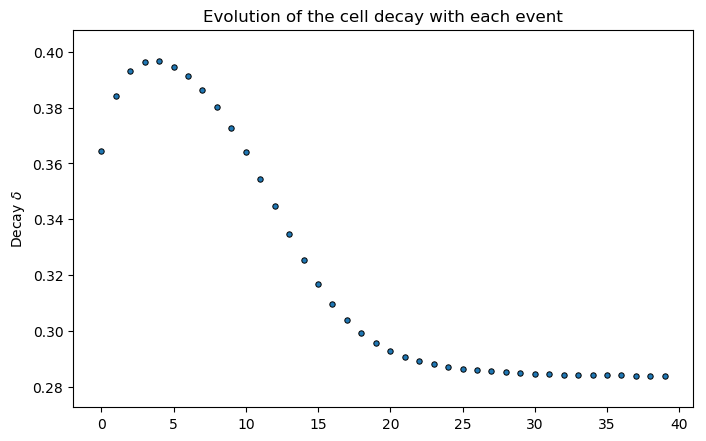

In [517]:
# Retrieve all cell decay values
all_decay_vals = [el['cell_decay'] for el in neural_gen.hidden_hist]
plt.figure(figsize=(8,5), dpi=100)
plt.scatter(np.array(range(len(all_decay_vals))), np.array(all_decay_vals),
            s=15, edgecolor='k', linewidth=.7)
plt.ylabel('Decay $\delta$')
plt.title("Evolution of the cell decay with each event")

In [518]:
time_vals, intens_vals = neural_gen.make_ctlstm_sequence_plot(200, tmax)

Text(0.5, 1.0, 'Intensity plot for neural Hawkes process')

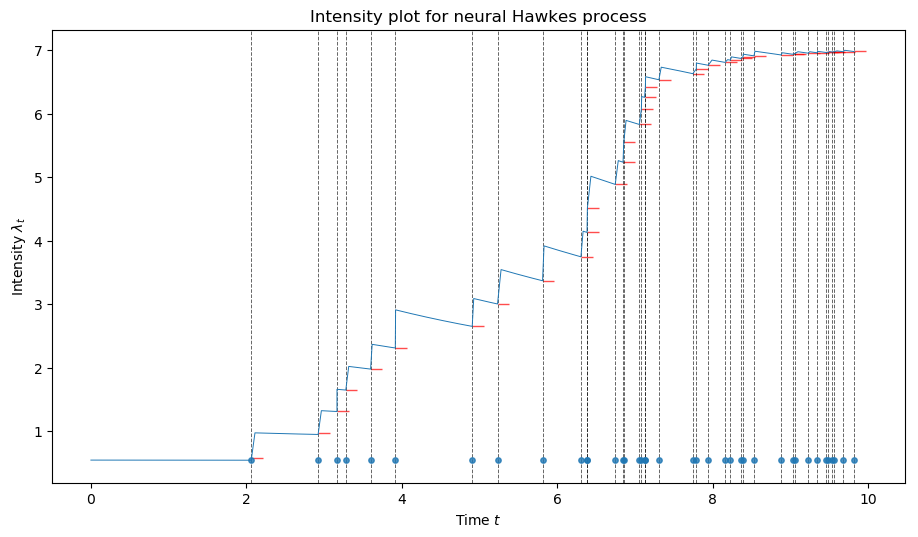

In [519]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6), dpi=100)
ax.plot(time_vals, intens_vals, linewidth=0.7)
for i,t in enumerate(neural_gen.sequence_):
    lbd = neural_gen.lbda_max_seq_[i+1]
    ax.axvline(t, ymin=0.0, ymax=intens_vals.max(), linewidth=0.7,
               linestyle='--',
               alpha=0.6, c='k', zorder=-1)
    ax.hlines(lbd.item(), xmin=t, xmax=t+0.15, colors='r',
              linewidth=1.0, alpha=0.7, zorder=-1)

ax.scatter(neural_gen.sequence_, intens_vals.min() + np.zeros_like(neural_gen.sequence_),
           s=15, alpha=0.8, zorder=1, )
ax.set_xlabel("Time $t$")
ax.set_ylabel("Intensity $\lambda_t$")
ax.set_title("Intensity plot for neural Hawkes process")